In [1]:
import pandas as pd
import numpy as np

In [2]:
from random import randrange
import time

In [3]:
from numpy import percentile
from numpy import sqrt, random, array, argsort


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [8]:
from sklearn.preprocessing import scale
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans

In [9]:
import os
import sys
from time import time

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
csv_file_path = 'cloudtrail.csv'

In [12]:
pd.set_option('display.max_rows', 200)

In [15]:
fields_to_encode = [ 'source', 'service', 'action', 'agent', 'arn'] # removed time, 'tactic1','tactic2'

In [17]:
# Select the columns you want to use for outlier detection
columns_for_outliers = [ 'source', 'service',  'action', 'agent', 'arn'] # removed time, 'tactic1','tactic2'

In [18]:
# Read the CSV file and extract relevant fields
df = pd.read_csv(csv_file_path, encoding='utf-8')  # Adjust the encoding if needed

In [19]:
df.dtypes

time       object
source     object
service    object
action     object
agent      object
arn        object
tactic1    object
tactic2    object
dtype: object

In [20]:
# sum uniuque field values, can inform pre-processing decisions
sum_n_unique = 0
for field in fields_to_encode:
    print(field)
    print(df[field].nunique())
    sum_n_unique += df[field].nunique()
    print(df[field].value_counts())
    print("==============")

source
48
source
vpc-flow-logs.amazonaws.com    21730
198.18.161.170                  3028
203.0.113.55                     141
72.21.217.49                      93
72.21.217.97                      55
198.18.14.103                     52
72.21.217.83                      38
72.21.217.73                      38
223.0.113.35                      36
72.21.217.117                     36
72.21.217.152                     36
72.21.217.47                      36
72.21.217.118                     36
72.21.217.109                     19
72.21.217.21                      19
72.21.217.223                     19
72.21.217.107                     19
72.21.217.129                     19
72.21.217.45                      19
72.21.217.70                      19
72.21.217.140                     19
72.21.217.71                      19
72.21.217.133                     19
72.21.217.75                      19
72.21.217.153                     19
72.21.217.85                      17
72.21.217.78         

In [21]:
print(sum_n_unique)

186


In [22]:
# print statistical summary, useful in assesing balance 
for field in fields_to_encode:
    print(field)
    print(df[field].value_counts().describe())
    print("==============")

source
count       48.000000
mean       534.916667
std       3154.450809
min          1.000000
25%          1.000000
50%         19.000000
75%         36.000000
max      21730.000000
Name: count, dtype: float64
service
count       20.000000
mean      1283.800000
std       4872.843962
min          1.000000
25%         15.250000
50%         20.000000
75%         36.500000
max      21749.000000
Name: count, dtype: float64
action
count       76.000000
mean       337.842105
std       2489.075818
min          1.000000
25%          3.000000
50%          9.500000
75%         37.500000
max      21730.000000
Name: count, dtype: float64
agent
count       29.000000
mean       885.379310
std       4052.179999
min          1.000000
25%          1.000000
50%          2.000000
75%          9.000000
max      21730.000000
Name: count, dtype: float64
arn
count        4.000000
mean      6419.000000
std      10374.811709
min          1.000000
25%          3.250000
50%       1972.500000
75%       8388.25000

In [23]:
print(df.shape)

(25676, 8)


#### Keep original data frame in df_orig

In [24]:
df_orig = df.copy()

In [25]:
#convert to categorical type and then to integers 
for field in fields_to_encode:
    df[field] = df[field].astype('category')
    df[field] = df[field].cat.codes

In [26]:
print(df)

                           time  source  service  action  agent  arn  tactic1  \
0      2018-09-25T12:06:16.000Z      47       19       1     28    0        0   
1      2018-09-25T12:06:16.000Z      47       19       1     28    0        0   
2      2018-09-25T12:41:50.000Z      47       19       1     28    0        0   
3      2018-09-25T12:26:18.000Z      47       19       1     28    0        0   
4      2018-09-25T12:31:50.000Z      47       19       1     28    0        0   
...                         ...     ...      ...     ...    ...  ...      ...   
25671  2018-12-20T22:12:06.000Z      15        5      72     24    1        3   
25672  2018-09-26T19:45:33.000Z      15        5      73     24    1        3   
25673  2018-12-18T21:47:24.000Z      15        5      73     24    1        3   
25674  2018-12-18T21:45:59.000Z      15        5      73     24    1        3   
25675  2018-12-18T03:36:41.000Z      15        5      74     25    1        1   

       tactic2  
0         

In [27]:
print(df.columns)

Index(['time', 'source', 'service', 'action', 'agent', 'arn', 'tactic1',
       'tactic2'],
      dtype='object')


In [28]:
print(df)

                           time  source  service  action  agent  arn  tactic1  \
0      2018-09-25T12:06:16.000Z      47       19       1     28    0        0   
1      2018-09-25T12:06:16.000Z      47       19       1     28    0        0   
2      2018-09-25T12:41:50.000Z      47       19       1     28    0        0   
3      2018-09-25T12:26:18.000Z      47       19       1     28    0        0   
4      2018-09-25T12:31:50.000Z      47       19       1     28    0        0   
...                         ...     ...      ...     ...    ...  ...      ...   
25671  2018-12-20T22:12:06.000Z      15        5      72     24    1        3   
25672  2018-09-26T19:45:33.000Z      15        5      73     24    1        3   
25673  2018-12-18T21:47:24.000Z      15        5      73     24    1        3   
25674  2018-12-18T21:45:59.000Z      15        5      73     24    1        3   
25675  2018-12-18T03:36:41.000Z      15        5      74     25    1        1   

       tactic2  
0         

#### Apply PCA for dimensionality reduction


In [29]:
#remove the mean and scale each feature/variable to unit variance
x = df.loc[:, columns_for_outliers].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [30]:
pca_2 = PCA(n_components=2)
X2 = pca_2.fit_transform(x)
#reduce dimensionality of the data so we can plot it

In [31]:
print(X2.shape)

(25676, 2)


 # change the number of components to 5

In [32]:
pca_5 = PCA(n_components=5) 
X = pca_5.fit_transform(x)  # ndarray of shape (n_samples, n_components)
# reduce dimensionality of the data so we can plot it - this time in five dimensions

In [33]:
print(X.shape)

(25676, 5)


In [34]:
# variable to represent a fraction of the data considered to be outliers 
num_samples = df.shape[0]
out_frac=0.001

In [35]:
fraction_of_inliers = (1. - out_frac) 
# (1 - fraction of outliers)
num_inliers = int(fraction_of_inliers * num_samples)
# fraction of inliers * total number of samples
num_outliers = int(out_frac * num_samples) 
# fraction of outliers * total number of samples

In [36]:
print('No. of inliers: %i' % num_inliers)
print('No. of outliers: %i' % num_outliers)

No. of inliers: 25650
No. of outliers: 25


In [37]:
random_state_number = 42
rs = np.random.RandomState(random_state_number)  
# random state - force the centroids to begin 
# in the same locations bc we are going to compare 
# different clusters 

In [38]:
print(type(X2))

<class 'numpy.ndarray'>


In [39]:
K=5 

In [40]:
begin = time()
kmeans = KMeans(n_clusters = K).fit(X2)
print(kmeans)
# init="random",n_clusters=K,n_init=10,max_iter=300,random_state=42
# generate five clusters

KMeans(n_clusters=5)


In [41]:
center = kmeans.cluster_centers_
print(center)
# output the centroids

[[-0.884974    0.02576361]
 [ 4.99542299 -0.4738105 ]
 [ 8.89641647 10.21165807]
 [ 4.01240067 -0.1144138 ]
 [ 6.9943361   3.84913734]]


# set percentile to adjust number of outliers

In [42]:
PERCENTILE=99.9

In [43]:
# Predict the closest cluster for each data point
closest_cluster = kmeans.predict(X2)
df['cluster'] = kmeans.predict(X2)

# Calculate the distance of each data point to its closest cluster center
distances = pairwise_distances_argmin_min(X2, kmeans.cluster_centers_)[1]

# Define a threshold to identify anomalies
threshold = np.percentile(distances, PERCENTILE)

# Find the indices of the anomalies
anomaly_indices = np.where(distances > threshold)[0]

# Print the indices of the anomalies
print("Anomaly indices:", anomaly_indices)
print(len(anomaly_indices))

Anomaly indices: [21743 21744 21745 21746 21747 21748 21749 21750 21751 21752 21753 21754
 21755 21756 21757 21758 21759 25494 25540 25541 25542 25543 25544 25603
 25604 25605]
26


In [44]:
# initialize two new rows in the dataframe
df['outlier_kmeans'] = 0
df['cluster'] = -1
# cc - set the value of the cluster column for each row
for index in range(df.shape[0]):
    df.at[index, 'cluster'] = closest_cluster[index]
# make it string to plot
    if index in anomaly_indices:
         df.at[index, 'outlier_kmeans'] = str(1) 

In [45]:
#create two new columns, c1 and c2, and populate them with values from a 2D array
df['c1'] = 0
df['c2'] = 0
for index in range(df.shape[0]):
    df.at[index, 'c1'] = X[index][0]
    df.at[index, 'c2'] = X[index][1]


In [46]:
end = time()
# total time taken

In [47]:
df.head()

,time,source,service,action,agent,arn,tactic1,tactic2,cluster,outlier_kmeans,c1,c2
0,2018-09-25T12:06:16.000Z,47,19,1,28,0,0,2,0,0,-0.884974,0.025764
1,2018-09-25T12:06:16.000Z,47,19,1,28,0,0,2,0,0,-0.884974,0.025764
2,2018-09-25T12:41:50.000Z,47,19,1,28,0,0,2,0,0,-0.884974,0.025764
3,2018-09-25T12:26:18.000Z,47,19,1,28,0,0,2,0,0,-0.884974,0.025764
4,2018-09-25T12:31:50.000Z,47,19,1,28,0,0,2,0,0,-0.884974,0.025764


In [48]:
df.query('outlier_kmeans == "1"')
# print the rows evaluated as outliers

,time,source,service,action,agent,arn,tactic1,tactic2,cluster,outlier_kmeans,c1,c2
21743,2018-09-30T17:30:21.000Z,17,18,3,3,1,5,1,2,1,6.675359,10.003369
21744,2018-09-29T13:58:43.000Z,15,18,3,4,1,5,1,2,1,6.566720,9.538602
21745,2018-09-30T19:52:25.000Z,14,18,3,7,1,5,1,2,1,6.029649,8.212845
21746,2018-09-26T18:08:45.000Z,15,18,3,8,1,5,1,2,1,5.794318,7.789204
21747,2018-09-27T19:17:58.000Z,15,18,3,9,1,5,1,4,1,5.601217,7.351854
21748,2018-09-29T20:40:05.000Z,15,18,3,9,1,5,1,4,1,5.601217,7.351854
21749,2018-09-28T16:36:10.000Z,15,18,3,9,1,5,1,4,1,5.601217,7.351854
21750,2018-12-19T13:44:00.000Z,15,18,3,12,1,5,1,4,1,5.021915,6.039805
21751,2018-12-19T20:02:32.000Z,16,18,3,13,1,5,1,4,1,4.786584,5.616165
21752,2018-12-17T17:03:57.000Z,15,18,3,7,1,5,1,2,1,5.987418,8.226553


In [49]:
print(len(df.query('outlier_kmeans == "1"')))
#count the number of outliers

26


In [50]:
print(closest_cluster)

[0 0 0 ... 1 1 1]


In [51]:
df.columns

Index(['time', 'source', 'service', 'action', 'agent', 'arn', 'tactic1',
       'tactic2', 'cluster', 'outlier_kmeans', 'c1', 'c2'],
      dtype='object')

In [52]:
print(X2)

[[-0.884974    0.02576361]
 [-0.884974    0.02576361]
 [-0.884974    0.02576361]
 ...
 [ 6.52775407 -0.80310612]
 [ 6.52775407 -0.80310612]
 [ 6.37182363 -1.24966019]]


In [53]:
print(len(X2))

25676


In [54]:
print(df.shape)

(25676, 12)


In [55]:
# create new series by selecting values from the columns at the positions 
# specified in anomaly_indices. This series will contain the c1 values of the 
# data points that are considered anomalies.
x_anom = df['c1'][anomaly_indices]
y_anom = df['c2'][anomaly_indices]

In [56]:
sns.set(rc={"figure.figsize":(15, 10)}) #width=15, #height=10

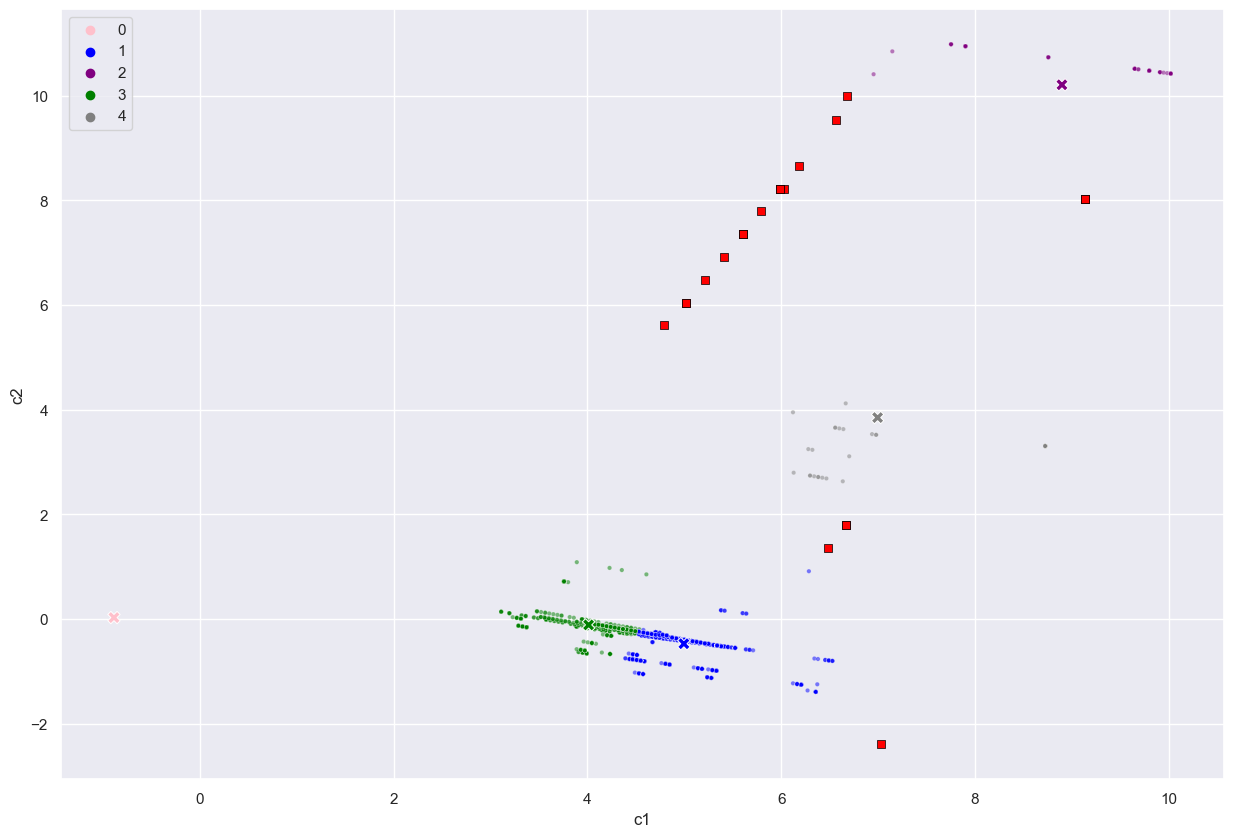

In [57]:
# pd.plotting.parallel_coordinates(X2, 'cluster')
# X -- cluster center
# s (square) = outlier
# use Seaborn's scatterplot function to plot the c1 and c2 columns
# from DataFrame df. The hue parameter is set to kmeans.labels_, 
# which are the labels assigned by a k-means clustering algorithm, 
# thereby coloring each point according to its cluster label.
colors = ['pink', 'blue', 'purple', 'green', 'grey']
ax = sns.scatterplot(x=df['c1'], y=df['c2'], hue=kmeans.labels_, palette=colors, 
                     alpha=0.5, s=10) 
# plot the centers of the clusters. The centers are accessed via kmeans.cluster_centers_,
# and hue=range(K) assigns a unique color to each center. The centers are plotted 
# with a larger size (s=80) and a different marker style (marker='X')
ax = sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1],
                     hue=range(K), palette=colors, s=80, marker='X', legend=False)
# hue = 'cluster'
# Anomalies are plotted with distinctive styling to make them stand out: 
# red color, square markers (marker='s'), larger size (s=40), and 
# a black edge (edgecolor='black').
sns.scatterplot(x=x_anom, y=y_anom, color="red", s=40, marker="s", edgecolor='black' )
# candidate values for our number of cluster
plt.show()

In [58]:
df_orig = pd.read_csv(csv_file_path)
print(df_orig.head(2))
df_orig.action.astype('str')
# Use iloc to select the specific rows evaluated as anomalies
selected_rows = df_orig.iloc[anomaly_indices]
selected_rows
# Search space reduction: filter rows where the cell value in 'action' does not start with 'Describe'

filtered_df = selected_rows.loc[~selected_rows['action'].str.startswith('Describe')]

# Printing the filtered DataFrame
filtered_df

                       time                       source            service  \
0  2018-09-25T12:06:16.000Z  vpc-flow-logs.amazonaws.com  sts.amazonaws.com   
1  2018-09-25T12:06:16.000Z  vpc-flow-logs.amazonaws.com  sts.amazonaws.com   

       action                        agent   arn            tactic1  \
0  AssumeRole  vpc-flow-logs.amazonaws.com  Null  Credential Access   
1  AssumeRole  vpc-flow-logs.amazonaws.com  Null  Credential Access   

            tactic2  
0  Lateral Movement  
1  Lateral Movement  


,time,source,service,action,agent,arn,tactic1,tactic2
21743,2018-09-30T17:30:21.000Z,223.0.113.35,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 ...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21744,2018-09-29T13:58:43.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 ...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21745,2018-09-30T19:52:25.000Z,198.18.14.103,signin.amazonaws.com,ConsoleLogin,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21746,2018-09-26T18:08:45.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21747,2018-09-27T19:17:58.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21748,2018-09-29T20:40:05.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21749,2018-09-28T16:36:10.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21750,2018-12-19T13:44:00.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,Mozilla/5.0 (iPad; CPU OS 12_1 like Mac OS X) ...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21751,2018-12-19T20:02:32.000Z,203.0.113.55,signin.amazonaws.com,ConsoleLogin,Mozilla/5.0 (iPhone; CPU iPhone OS 12_0_1 like...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21752,2018-12-17T17:03:57.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,arn:aws:iam::123456789012:root,Persistence,Initial Access


#  dynamic K 

In [59]:
# scale numerical data in a pandas DataFrame using the StandardScaler 
df_scaled = df[fields_to_encode].copy()
df_scaled[df_scaled.columns] = StandardScaler().fit_transform(df_scaled)
print(df_scaled.describe())

# creates a PCA object configured to reduce the dataset to two dimensions. 
# The parameter n_components=2 keeps the two most significant
# principal components.
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(df_scaled)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(
    np.sum(pca_2.explained_variance_ratio_)))

# Results from pca.components_
# create a new DataFrame, dataset_pca, from the absolute values
# of the components_ attribute of the pca_2 object. 
# The rows of this DataFrame correspond to the principal components (PC_1 and PC_2),
# and the columns correspond to the original features from df_scaled.
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=df_scaled.columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)
# filter the components, retaining only those loadings that are greater
# than 0.3, indicating a substantial contribution to the variance captured 
# by the principal component.iloc[0] and .iloc[1] are used to select 
# the respective rows for PC_1 and PC_2. dropna() is applied to remove any 
# features that do not meet the threshold, simplifying the output to only
# include relevant features.
print("\n*************** Most important features *************************")
print('As per PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())
print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
print("\n******************************************************************")

             source       service        action         agent           arn  \
count  2.567600e+04  2.567600e+04  2.567600e+04  2.567600e+04  2.567600e+04   
mean  -3.719308e-16 -5.136187e-16  5.313297e-17  3.896418e-16  5.313297e-17   
std    1.000019e+00  1.000019e+00  1.000019e+00  1.000019e+00  1.000019e+00   
min   -3.906865e+00 -3.482285e+00 -4.719854e-01 -1.326349e+01 -4.256291e-01   
25%    4.119702e-01  4.161110e-01 -3.890323e-01  3.295749e-01 -4.256291e-01   
50%    4.119702e-01  4.161110e-01 -3.890323e-01  3.295749e-01 -4.256291e-01   
75%    4.119702e-01  4.161110e-01 -3.890323e-01  3.295749e-01 -4.256291e-01   
max    4.119702e-01  4.161110e-01  5.749494e+00  3.295749e-01  7.870261e+00   

            tactic1       tactic2  
count  2.567600e+04  2.567600e+04  
mean  -1.062659e-16  3.542198e-17  
std    1.000019e+00  1.000019e+00  
min   -4.209699e-01 -2.351686e+00  
25%   -4.209699e-01  4.258337e-01  
50%   -4.209699e-01  4.258337e-01  
75%   -4.209699e-01  4.258337e-01  


In [60]:
print(dataset_pca)

        source   service    action     agent       arn   tactic1   tactic2
PC_1  0.384023  0.383368  0.370484  0.325645  0.393317  0.391062  0.393224
PC_2  0.108630  0.310996  0.050482  0.922003  0.126010  0.032910  0.147926


Parameter: {'n_clusters': 2} Score 0.9586624826425918
Parameter: {'n_clusters': 3} Score 0.9642327545639617
Parameter: {'n_clusters': 4} Score 0.9171876195132868
Parameter: {'n_clusters': 5} Score 0.9270906295775991
Parameter: {'n_clusters': 10} Score 0.9336106633412323
Parameter: {'n_clusters': 15} Score 0.9405500256342987
Parameter: {'n_clusters': 20} Score 0.9432934772985395
Parameter: {'n_clusters': 25} Score 0.9474523732786685
Parameter: {'n_clusters': 30} Score 0.9504724003849274
Parameter: {'n_clusters': 35} Score 0.9515110975964817
Parameter: {'n_clusters': 40} Score 0.9490305014782113


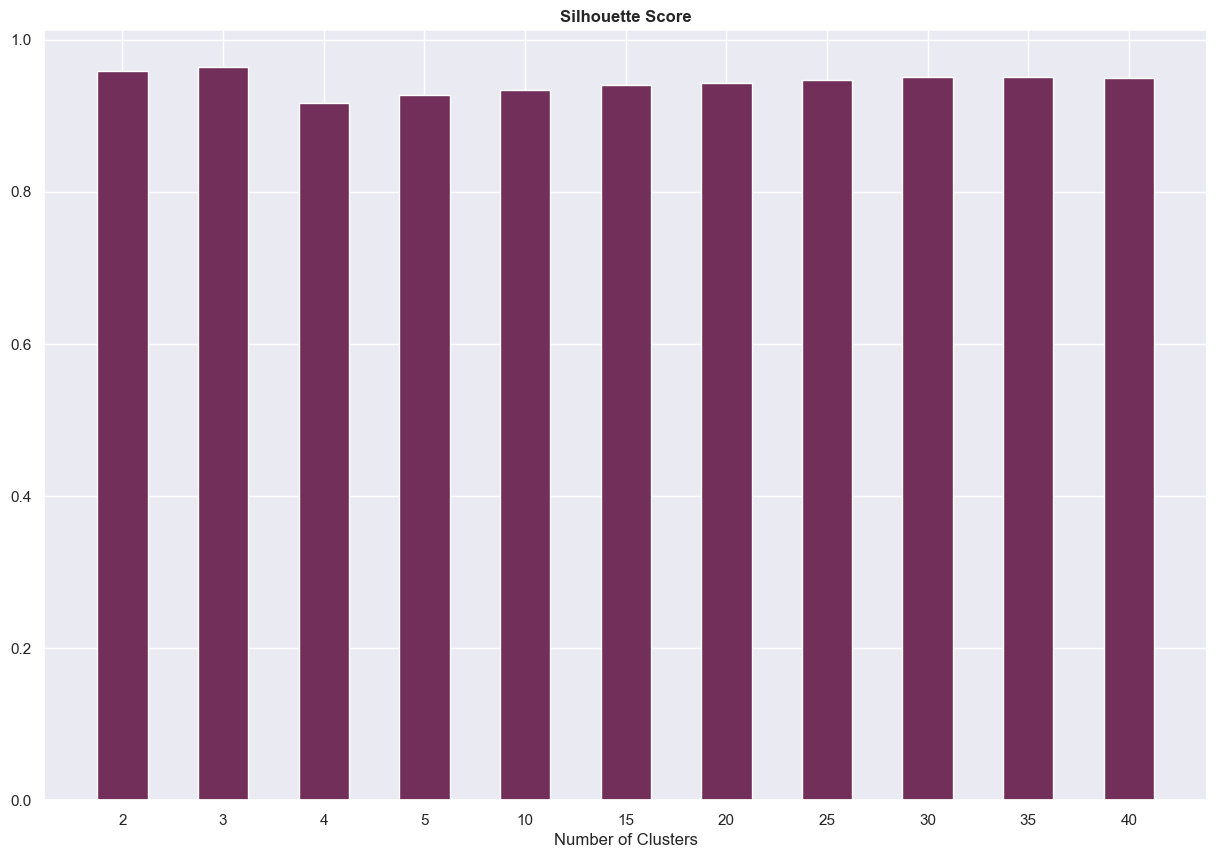

3


In [61]:
# candidate values for our number of cluster
parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]

# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})

best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []

# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(df_scaled)          # fit model on wine dataset, this will find clusters based on parameter p

    ss = metrics.silhouette_score(df_scaled, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores

    print('Parameter:', p, 'Score', ss)

    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p

# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

optimum_num_clusters = best_grid['n_clusters']
print(best_grid['n_clusters'])

###we are reusing some variable names here rerun notebook

In [62]:
 # fitting KMeans
kmeans_n = KMeans(n_clusters=optimum_num_clusters)
kmeans_n.fit(df_scaled)
centroids = kmeans_n.cluster_centers_
centroids_pca = pca_2.transform(centroids)

In [63]:
print("Optimum number of clusters= "+ str(optimum_num_clusters))

Optimum number of clusters= 3


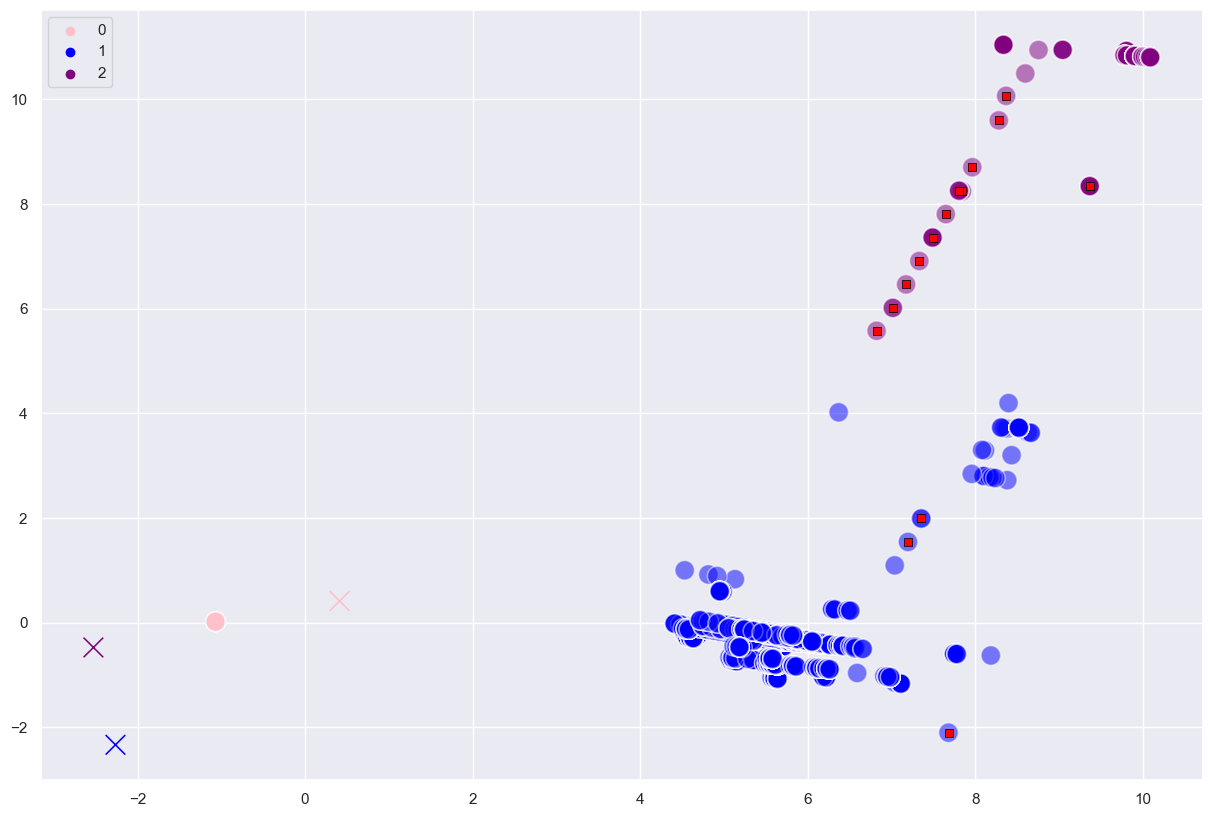

In [64]:
x = pca_2_result[:, 0]
y = pca_2_result[:, 1]

x_anom = pca_2_result[anomaly_indices,0]
y_anom = pca_2_result[anomaly_indices,1]

colors2 = ['pink', 'blue', 'purple', 'green', 'grey']

ax = sns.scatterplot(x=x, y=y, hue=kmeans_n.labels_, palette=colors2, alpha=0.5, s=200) 
ax = sns.scatterplot(x=kmeans_n.cluster_centers_[:,0], y=kmeans_n.cluster_centers_[:,1],
                      #x=centroids_pca[:, 0], y=centroids_pca[:, 1], 
                     hue=range(optimum_num_clusters), 
                     palette=colors2, marker='x', s=200, linewidths=1.5, legend=False) # s is square 
sns.scatterplot(x=x_anom, y=y_anom, color="red", s=40, marker="s", edgecolor='black'  )
# candidate values for our number of cluster

plt.show()

In [65]:
df_scaled.head(20)

,source,service,action,agent,arn,tactic1,tactic2
0,0.41197,0.416111,-0.389032,0.329575,-0.425629,-0.42097,0.425834
1,0.41197,0.416111,-0.389032,0.329575,-0.425629,-0.42097,0.425834
2,0.41197,0.416111,-0.389032,0.329575,-0.425629,-0.42097,0.425834
3,0.41197,0.416111,-0.389032,0.329575,-0.425629,-0.42097,0.425834
4,0.41197,0.416111,-0.389032,0.329575,-0.425629,-0.42097,0.425834
5,0.41197,0.416111,-0.389032,0.329575,-0.425629,-0.42097,0.425834
6,0.41197,0.416111,-0.389032,0.329575,-0.425629,-0.42097,0.425834
7,0.41197,0.416111,-0.389032,0.329575,-0.425629,-0.42097,0.425834
8,0.41197,0.416111,-0.389032,0.329575,-0.425629,-0.42097,0.425834
9,0.41197,0.416111,-0.389032,0.329575,-0.425629,-0.42097,0.425834
